## Sentinel-3 L1 OLCI Natural Colour Mosaics via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'sentinelhub'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub'

In [3]:
# add repo source directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )
sys.path.insert(0, os.path.join( root_path, 'notebooks' ) )

In [4]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-3' )
cfg_path

'C:\\Users\\Chris.Williams\\Documents\\GitHub\\sentinelhub\\cfg\\sentinel-3'

### _Load configuration file from repository cfg sub-directory_ 

In [5]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's3-mosaic-olci-natural.yml' )

In [6]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    collection: SENTINEL3_OLCI
    evalscript: |
                //VERSION=3
                function setup() {
                  return {
                    input: ["B08", "B06", "B04"],
                    output: { 
                      bands: 3,
                      sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].
                    }
                  }
                }
                function evaluatePixel(sample) {
                    var lambda = 7.0;
                    var RED_offset = 0.03;
                    var GREEN_offset = 0.05;
                    var BLUE_offset = 0.08;

                    var R = sample.B08 - RED_offset;
                    var G = sample.B06 - GREEN_offset;
                    var B = sample.B04 - BLUE_offset;

                    if (R < 0) {R=0.0};
                    if (G < 0) {G=0.0};
                    if (B < 0) {B=0.0};

                    var RED = 2*(1/(1 + Math.exp(-lambda*R))-0.5);


In [7]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define area of interest collocated with Aegean Sea_

In [8]:
# define min and max latlons - see http://bboxfinder.com/
coords = 22.059448,36.049099,26.329834,39.160734
resolution = 300

In [9]:
# create instance of shclient class
from client import ShClient
client = ShClient( config )

In [10]:
# get epsg 3857 bbox - use global crs due to large area 
bbox = client.getBoundingBox( coords, dst_crs=3857 )
print ( bbox, bbox.crs.value )

2455646.518540697,4307379.423562267,2931023.7135514216,4744721.560631816 3857


In [11]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1291, 1114)

### _Generate 48 hour aggregated OLCI Natural Colour mosaics over Aegean Sea for May 2021_ 

In [12]:
# pick a few dates
from datetime import datetime

timeframes = []; step = 2
for day in range( 10, 20, step ):
    timeframes.append( { 'start' : datetime( 2021, 5, day, 0, 0, 0 ), 
                            'end' : datetime( 2021, 5, day + step - 1, 23, 59, 59 ) } )
timeframes

[{'start': datetime.datetime(2021, 5, 10, 0, 0),
  'end': datetime.datetime(2021, 5, 11, 23, 59, 59)},
 {'start': datetime.datetime(2021, 5, 12, 0, 0),
  'end': datetime.datetime(2021, 5, 13, 23, 59, 59)},
 {'start': datetime.datetime(2021, 5, 14, 0, 0),
  'end': datetime.datetime(2021, 5, 15, 23, 59, 59)},
 {'start': datetime.datetime(2021, 5, 16, 0, 0),
  'end': datetime.datetime(2021, 5, 17, 23, 59, 59)},
 {'start': datetime.datetime(2021, 5, 18, 0, 0),
  'end': datetime.datetime(2021, 5, 19, 23, 59, 59)}]

In [13]:
# leastcc mosaic option not supported for s3 - cloud mask ATBD still under development
request = client.getRequest( bbox, timeframes [ 0 ], resolution )
request.payload

{'input': {'bounds': {'properties': {'crs': 'http://www.opengis.net/def/crs/EPSG/0/3857'},
   'bbox': [2455646.518540697,
    4307379.423562267,
    2931023.7135514216,
    4744721.560631816]},
  'data': [InputDataDict({'type': 'sentinel-3-olci', 'dataFilter': {'timeRange': {'from': '2021-05-10T00:00:00Z', 'to': '2021-05-11T23:59:59Z'}, 'mosaickingOrder': 'mostRecent'}}, service_url=https://creodias.sentinel-hub.com)]},
 'evalscript': '//VERSION=3\nfunction setup() {\n  return {\n    input: ["B08", "B06", "B04"],\n    output: { \n      bands: 3,\n      sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].\n    }\n  }\n}\nfunction evaluatePixel(sample) {\n    var lambda = 7.0;\n    var RED_offset = 0.03;\n    var GREEN_offset = 0.05;\n    var BLUE_offset = 0.08;\n\n    var R = sample.B08 - RED_offset;\n    var G = sample.B06 - GREEN_offset;\n    var B = sample.B04 - BLUE_offset;\n\n    if (R < 0) {R=0.0};\n    if (G < 0) {G=0.0};\n    if (B < 0) {B=0.0};\

### _Visualise S3 OLCI mosaic imagery downloaded via Process API client_

In [14]:
# get mosaics between timeframes
response = client.getMosaics ( bbox, timeframes, resolution )
response._df

default      start  \
0  [[[25, 19, 0], [37, 27, 1], [33, 26, 1], [37, ... 2021-05-10   
1  [[[84, 81, 66], [69, 71, 58], [69, 71, 58], [7... 2021-05-12   
2  [[[254, 253, 254], [254, 253, 254], [254, 253,... 2021-05-14   
3  [[[73, 73, 59], [68, 70, 57], [68, 70, 57], [6... 2021-05-16   
4  [[[35, 26, 2], [42, 32, 5], [40, 32, 5], [43, ... 2021-05-18   

                  end  
0 2021-05-11 23:59:59  
1 2021-05-13 23:59:59  
2 2021-05-15 23:59:59  
3 2021-05-17 23:59:59  
4 2021-05-19 23:59:59

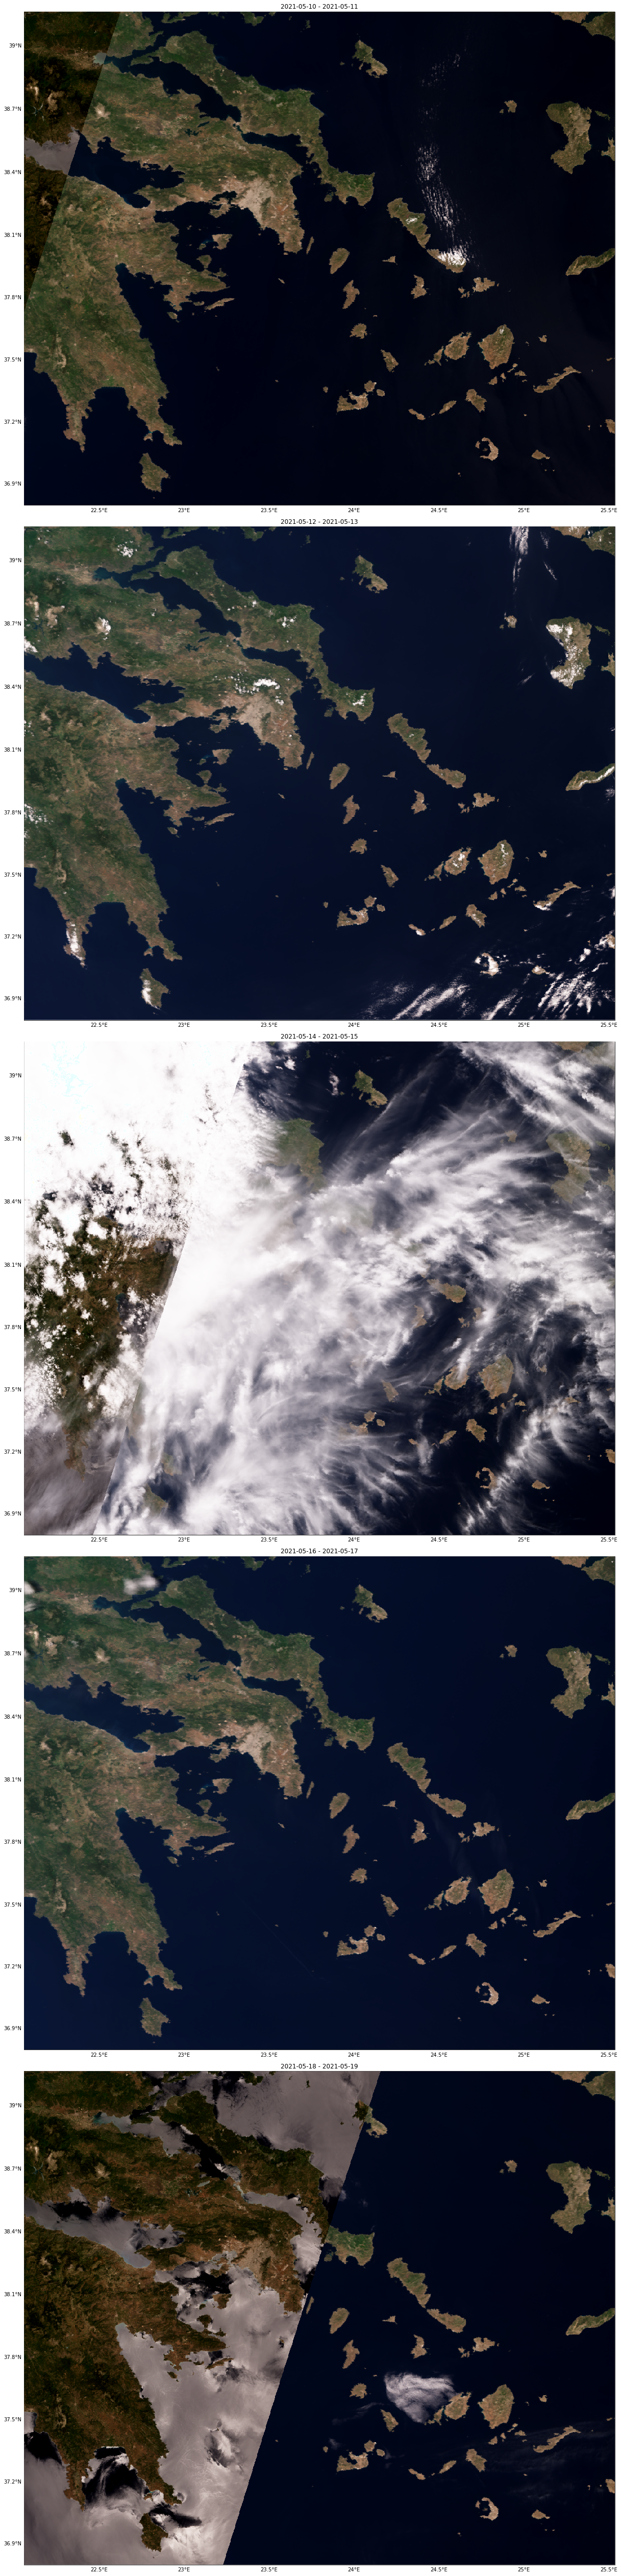

In [15]:
response.plotImages( 'default', alpha={ 'data': 1.0, 'grid' : 0.0 } )